# Import Libraries

In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, cohen_kappa_score, f1_score, balanced_accuracy_score, accuracy_score
from sklearn.metrics import matthews_corrcoef as mcc

# Data Reading

In [40]:
cancerData = pd.read_csv('TCGAdata.txt', sep=' ')
cancerData.shape
# cancerData.head()

(2887, 2000)

In [41]:
cancerLabel = pd.read_csv('TCGAlabels', sep=' ')
cancerLabel.shape

(2887, 1)

# Data Preprocessing and Data Visualization

In [42]:
cancerData['cancer'] = cancerLabel

In [43]:
data_shuffled = cancerData.sample(frac=1.0, random_state=0)
X = data_shuffled.drop('cancer', axis=1)
y = data_shuffled['cancer']

In [44]:
type(X)

pandas.core.frame.DataFrame

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


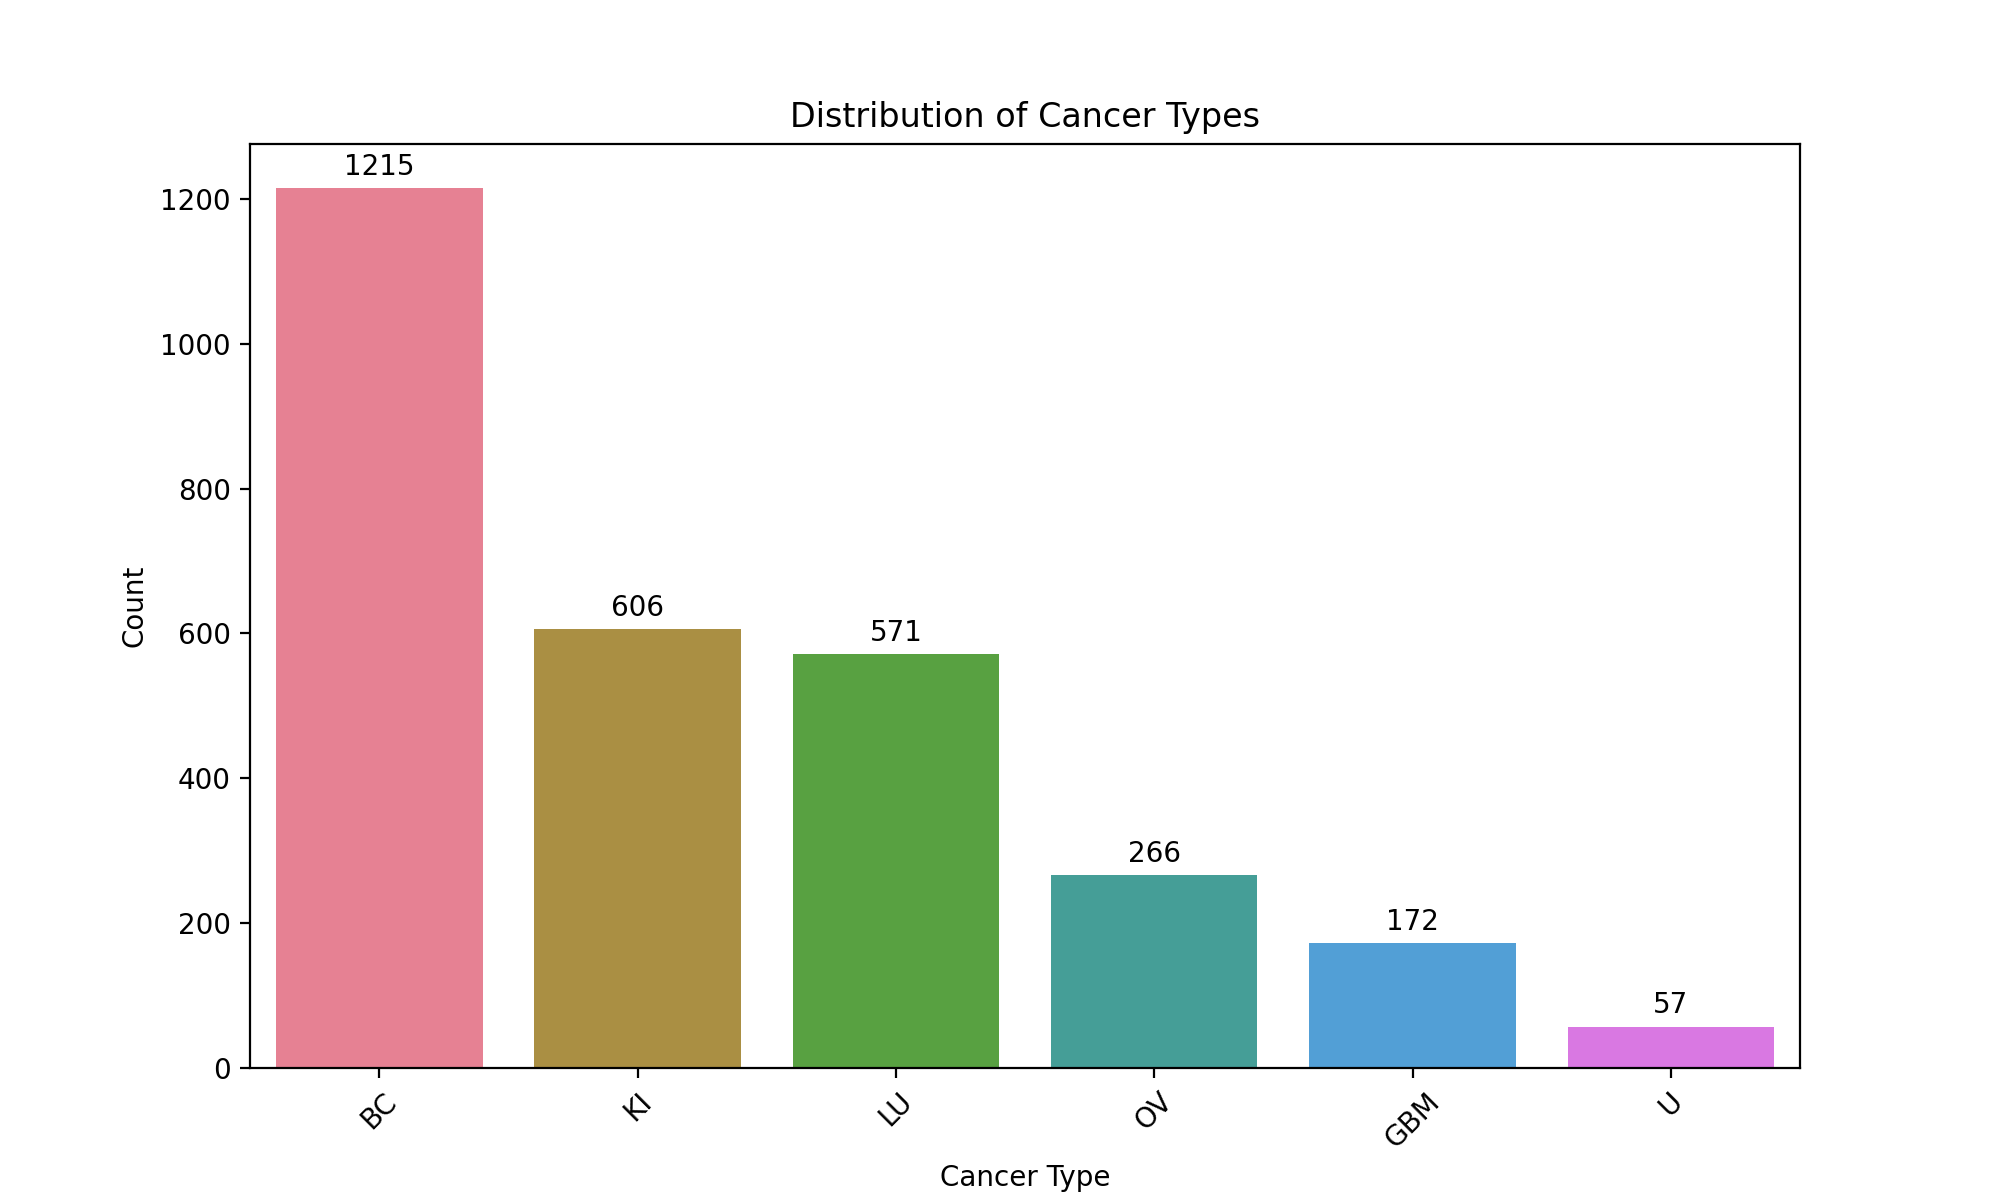

In [45]:
label_counts = y.value_counts()
colors = sns.color_palette("husl", len(label_counts))

# Plotting distribution of cancer types
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors, hue=label_counts.index)
plt.title('Distribution of Cancer Types')
plt.xlabel('Cancer Type')
plt.ylabel('Count')

# Add data labels
for i, count in enumerate(label_counts.values):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.legend().remove()  # Remove legend
plt.show()

In [46]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(
    X, y,
    # todo whether to turn on the 'stratify'
    stratify= y,
    test_size=0.25,
    random_state=0)

# Part 1

## Basics for PCA

In [47]:
pca = PCA(n_components=50, whiten=True, random_state=0).fit(X_train0)
X_train_pca0 = pca.transform(X_train0)
X_test_pca0 = pca.transform(X_test0)

print("X_train_pca.shape: {}".format(X_train_pca0.shape))

X_train_pca.shape: (2165, 50)


In [48]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_pca0, y_train0)
print(f"Test set accuracy: {knn.score(X_test_pca0, y_test0)}")

Test set accuracy: 0.9847645429362881


The variance explained, we better limit the pc number to 30 for optimum search

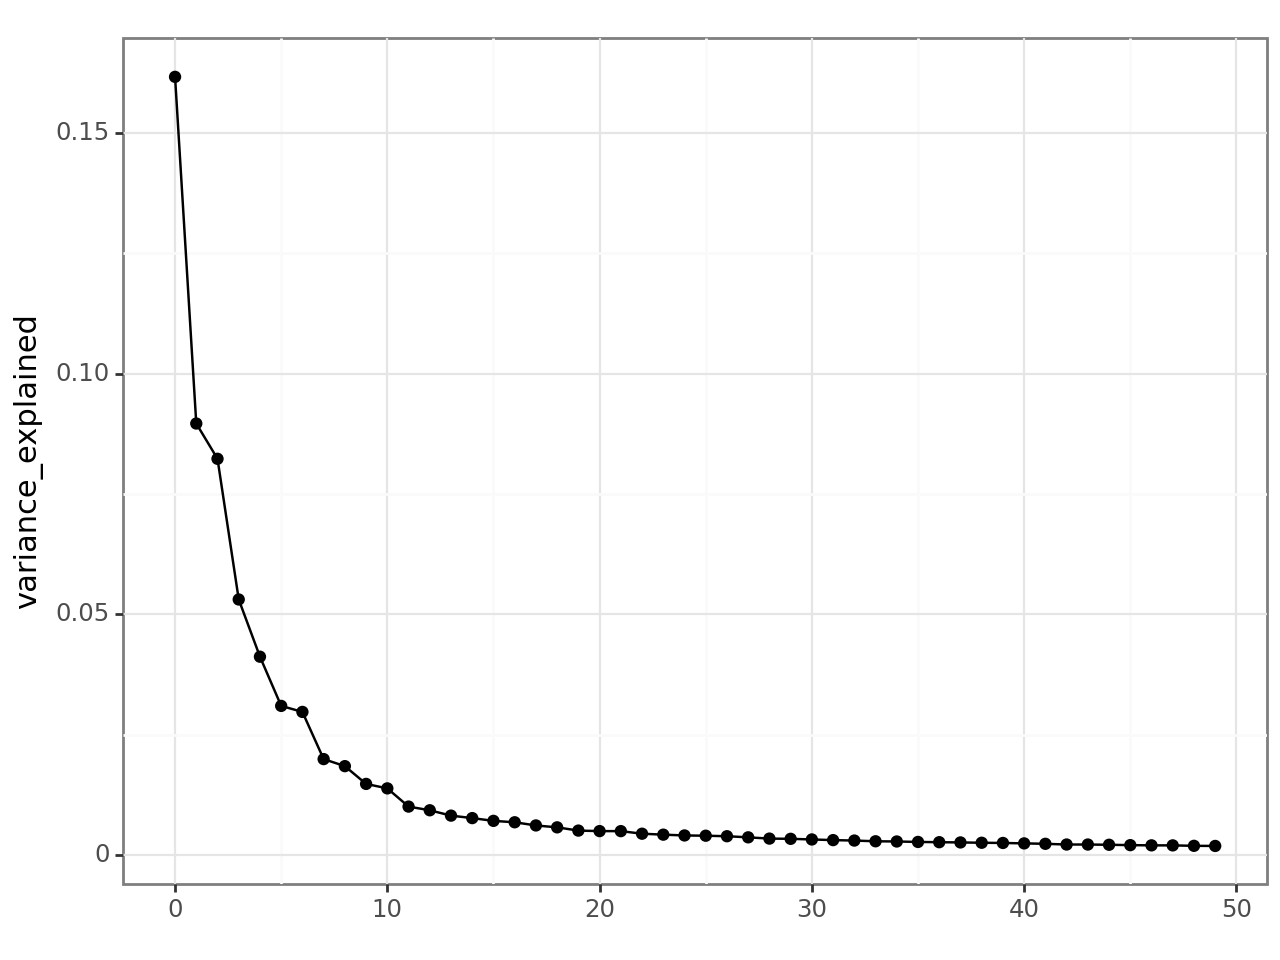

<Figure Size: (640 x 480)>

In [49]:
pca.explained_variance_ratio_
variance_explained = pd.DataFrame(pca.explained_variance_ratio_)
variance_explained.columns = ['variance_explained']

p = (ggplot(variance_explained, aes(x=variance_explained.index, y='variance_explained'))
     + geom_line()
     + geom_point()
     + theme_minimal()
     + theme_bw()
     )
p

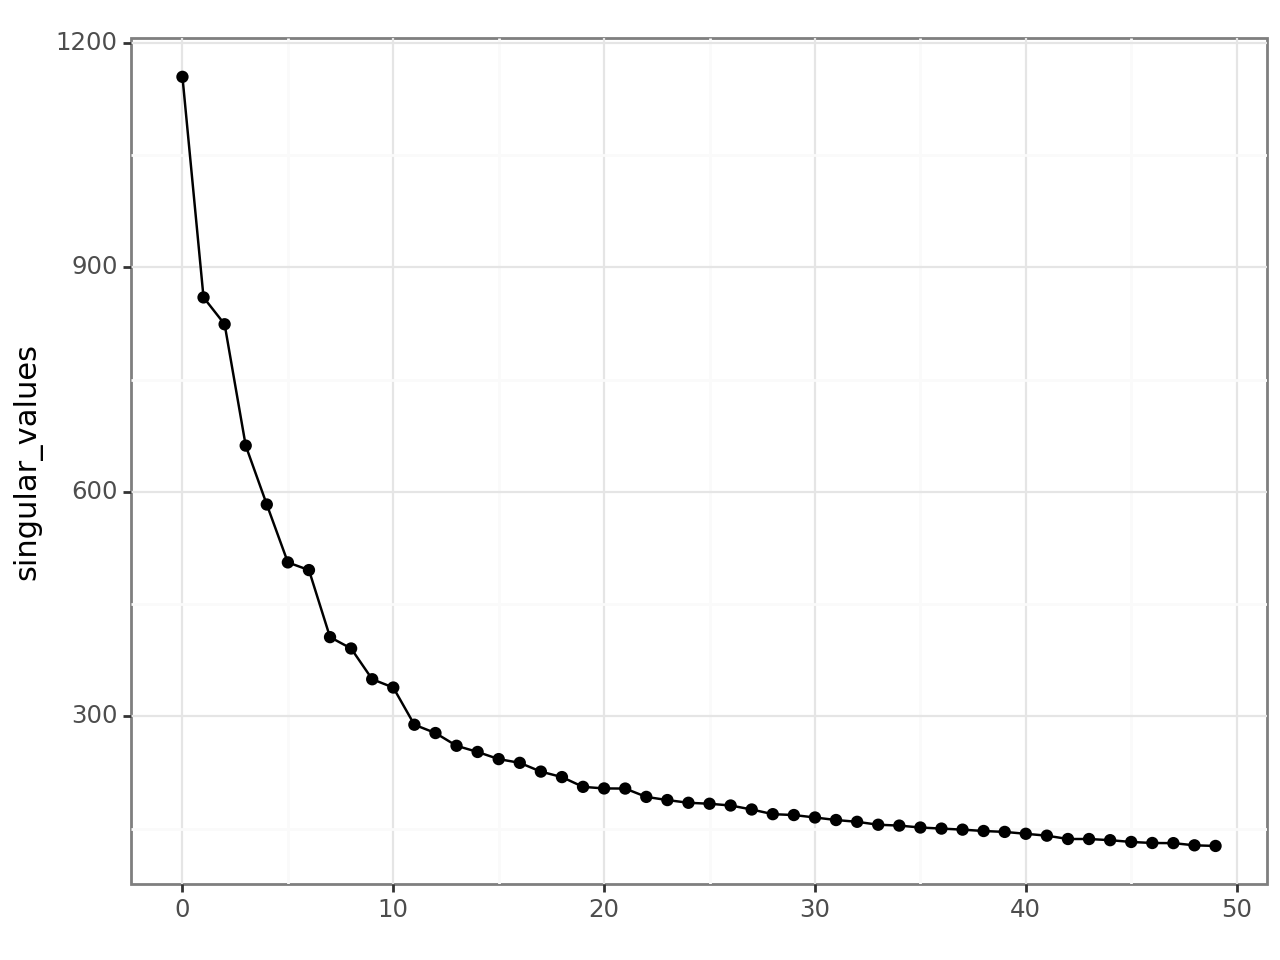

<Figure Size: (640 x 480)>

In [50]:
pca.singular_values_
eigenvalues = pd.DataFrame(pca.singular_values_)
eigenvalues.columns = ['singular_values']

p = (ggplot(eigenvalues, aes(x=variance_explained.index, y='singular_values'))
     + geom_line()
     + geom_point()
     + theme_minimal()
     + theme_bw()
     )
p

# Part 2

## Use other metrics including MCC, Kappa, f1 score and balanced accuracy to select number of principal components.

In [51]:
class ModelEvaluator:
    def __init__(self, X_train, X_test, y_train, y_test, external_param=None):
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        self.clf, self.clf_name = self.clf_category(external_param)
        self.pca = PCA(n_components=50).fit(self.X_train)
        self.X_train_pca = self.pca.transform(self.X_train)
        self.X_test_pca = self.pca.transform(self.X_test)

    def clf_category(self, clf_name = None):
        if clf_name is not None:
            # return KNeighborsClassifier(), 'n_neighbors'
            if clf_name == 'knn':
                knn = KNeighborsClassifier()
                return knn, 'knn'
            if clf_name == 'dtree':
                dtree = DecisionTreeClassifier()
                return dtree, 'dtree'
            if clf_name == 'SVC':
                svc = SVC()
                return svc, 'SVC'
            if clf_name == 'RF':
                rf = RandomForestClassifier(n_jobs=-1, n_estimators = 10)
                return rf, 'RF'
        else :
            return KNeighborsClassifier(), 'knn'

    def find_optimal_pc_with_cv(self, k, scoring='accuracy'):
        if self.clf_name == 'knn':
            self.clf.n_neighbors = k
        elif self.clf_name == 'dtree':
            self.clf.max_depth = k
        elif self.clf_name == 'SVC':
            self.clf.C = k
        elif self.clf_name == 'RF':
            self.clf.max_depth = k
        else:
            raise ValueError("Invalid type")

        # Determine the scorer function based on input
    def find_optimal_pc_with_cv(self, k, scoring='accuracy'):
        # Configure classifier
        if self.clf_name == 'knn':
            self.clf.n_neighbors = k
        elif self.clf_name == 'dtree' or self.clf_name == 'RF':
            self.clf.max_depth = k
        elif self.clf_name == 'SVC':
            self.clf.C = k

        scorer = {
            'kappa': make_scorer(cohen_kappa_score),
            'MCC': make_scorer(mcc),
            'f1_macro': make_scorer(f1_score, average='macro'),
            'balanced_accuracy': make_scorer(balanced_accuracy_score)
        }


        optimal_pc = None
        max_score = float('-inf')
        pc_num = 50
        avg_score = np.zeros(pc_num)
        # 0~50 PC choice

        # Use cv to find best pca number.
        for n_pc in range(1, pc_num):
            self.clf.fit(self.X_train_pca[:,:n_pc], self.y_train)
            avg_score[n_pc] = cross_val_score(self.clf, self.X_train_pca[:,:n_pc], self.y_train, scoring=scorer[scoring]).mean()

        max_score = np.max(avg_score)
        optimal_pc = np.argmax(avg_score)

        self.clf.fit(self.X_train_pca[:,:optimal_pc], self.y_train)
        max_score = cross_val_score(self.clf, self.X_train_pca[:,:optimal_pc], self.y_train).mean()
        max_train_score = self.clf.score(self.X_train_pca[:, :optimal_pc], self.y_train)
        max_test_score = self.clf.score(self.X_test_pca[:, :optimal_pc], self.y_test)

        return optimal_pc, max_score, max_train_score, max_test_score

## KNN

In [52]:
# results_df1 = pd.DataFrame(columns=['trainning size', 'k', 'optimal_pc', 'cv_accuracy', 'train_accuracy', 'test_accuracy'])
results_dfknn = pd.DataFrame(columns=['trainning size', 'k', 'optimal_pc', 'cv_kappa', 'training_kappa', 'test_kappa'])

for q in [1, 2, 3]:
    size = q * 0.25

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        stratify=y,
        train_size=size,
        random_state=0)

    evaluator = ModelEvaluator(X_train, X_test, y_train, y_test, 'knn')


    for k in range(1, 50):
        optimal_pc, cv_kappa, train_kappa, test_kappa = evaluator.find_optimal_pc_with_cv(k, scoring='kappa')
        results_dfknn.loc[len(results_dfknn)] = [size, k, optimal_pc, cv_kappa, train_kappa, test_kappa]

print(results_dfknn.head())

   trainning size    k  optimal_pc  cv_kappa  training_kappa  test_kappa
0            0.25  1.0         7.0  0.981983        1.000000    0.985226
1            0.25  2.0         6.0  0.977816        0.983356    0.984303
2            0.25  3.0        45.0  0.981983        0.988904    0.991228
3            0.25  4.0        45.0  0.984761        0.986130    0.989843
4            0.25  5.0        26.0  0.986140        0.984743    0.994922


d:\anaconda3\lib\site-packages\mizani\scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
d:\anaconda3\lib\site-packages\mizani\scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


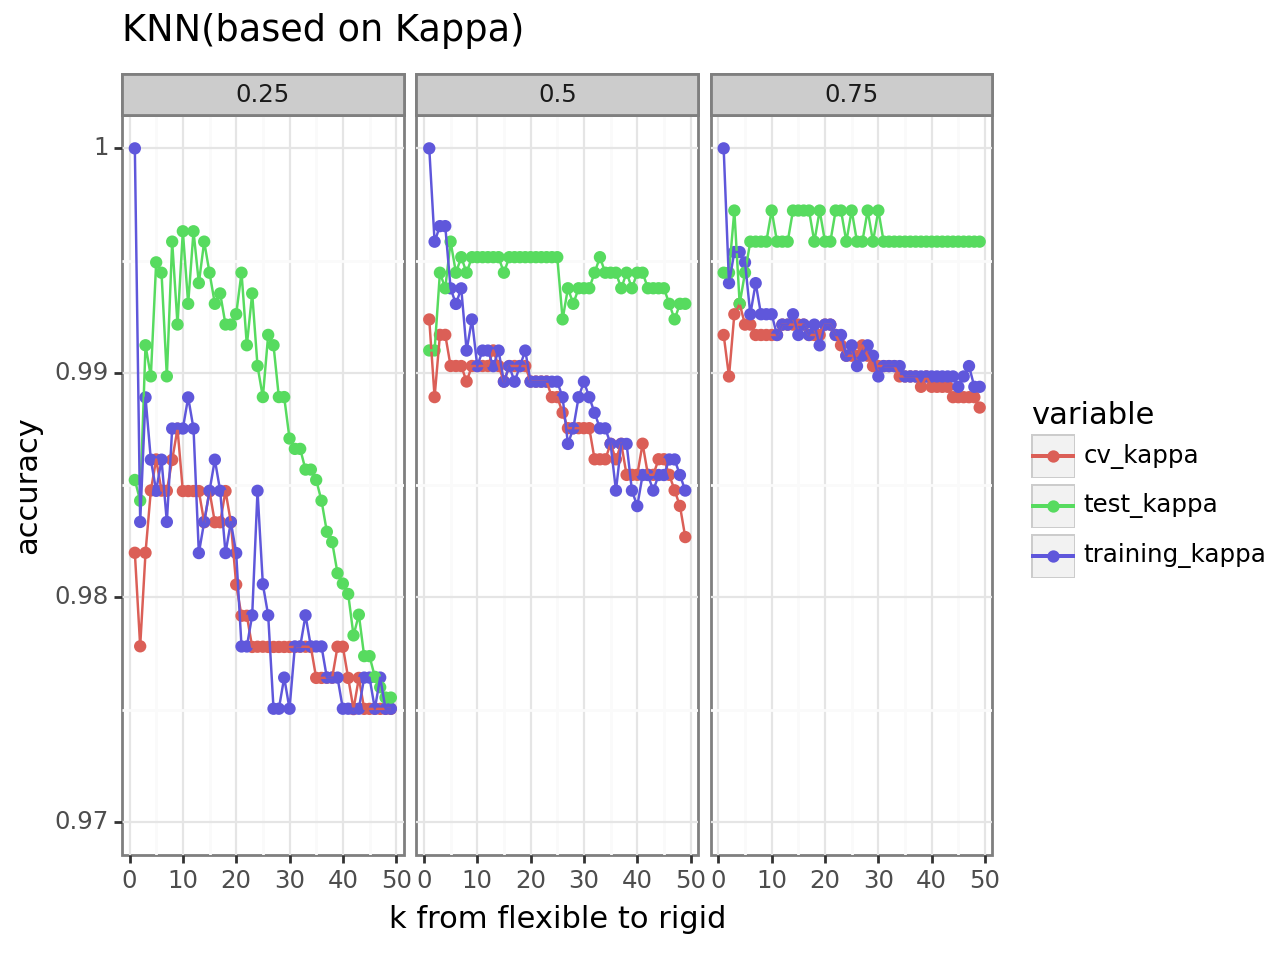

<Figure Size: (640 x 480)>

In [58]:
df_results_dfknn = pd.melt(results_dfknn, id_vars=["k", 'trainning size'], value_vars=["cv_kappa", 'training_kappa', 'test_kappa'])
p1 = (ggplot(df_results_dfknn, aes(x = 'k', y = 'value', color = 'variable'))
      + geom_point()
      + geom_line()
      + facet_wrap('trainning size', nrow = 1)
      + labs(x = 'k from flexible to rigid', y = 'accuracy', title = 'KNN(based on Kappa)')
      + theme_minimal()
      + ylim(0.97, 1)
      + theme_bw()
      )
p1

In [59]:
results_dfknn2 = pd.DataFrame(columns=['trainning size', 'k', 'optimal_pc', 'cv_mcc', 'training_mcc', 'test_mcc'])

for q in [1, 2, 3]:
    size = q * 0.25

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        stratify=y,
        train_size=size,
        random_state=0)

    evaluator = ModelEvaluator(X_train, X_test, y_train, y_test, 'knn')


    for k in range(1, 50):
        optimal_pc, cv_mcc, training_mcc, test_mcc = evaluator.find_optimal_pc_with_cv(k, scoring='MCC')
        results_dfknn2.loc[len(results_dfknn2)] = [size, k, optimal_pc, cv_mcc, training_mcc, test_mcc]

print(results_dfknn2.head())

   trainning size    k  optimal_pc    cv_mcc  training_mcc  test_mcc
0            0.25  1.0         7.0  0.981983      1.000000  0.985226
1            0.25  2.0         6.0  0.977816      0.983356  0.984303
2            0.25  3.0        43.0  0.981983      0.987517  0.989843
3            0.25  4.0        44.0  0.984761      0.987517  0.990766
4            0.25  5.0        26.0  0.986140      0.984743  0.994922


d:\anaconda3\lib\site-packages\mizani\scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
d:\anaconda3\lib\site-packages\mizani\scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


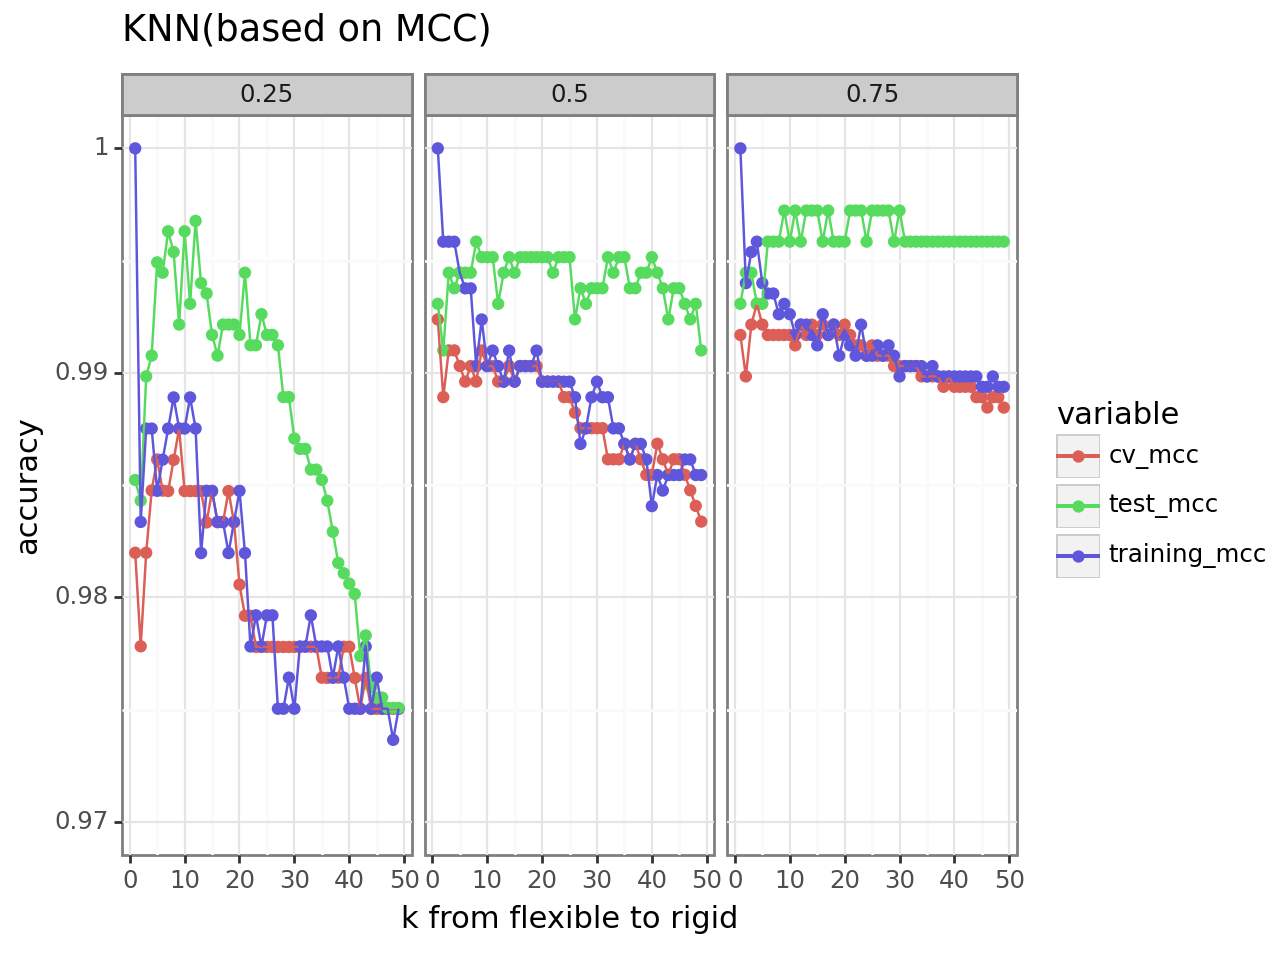

<Figure Size: (640 x 480)>

In [60]:
df_results_dfknn2 = pd.melt(results_dfknn2, id_vars=["k", 'trainning size'], value_vars=["cv_mcc", 'training_mcc', 'test_mcc'])
p1 = (ggplot(df_results_dfknn2, aes(x = 'k', y = 'value', color = 'variable'))
      + geom_point()
      + geom_line()
      + facet_wrap('trainning size', nrow = 1)
      + labs(x = 'k from flexible to rigid', y = 'accuracy', title = 'KNN(based on MCC)')
      + ylim(0.97, 1)
      # + ylim(0.9)
      + theme_minimal()
      + theme_bw()
      )
p1

In [61]:
results_dfknn = pd.DataFrame(columns=['trainning size', 'k', 'optimal_pc', 'cv_bacc', 'training_bacc', 'test_bacc'])

for q in [1, 2, 3]:
    size = q * 0.25

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        stratify=y,
        train_size=size,
        random_state=0)

    evaluator = ModelEvaluator(X_train, X_test, y_train, y_test, 'knn')


    for k in range(1, 50):
        optimal_pc, cv_bacc, training_bacc, test_bacc = evaluator.find_optimal_pc_with_cv(k, scoring='balanced_accuracy')
        results_dfknn.loc[len(results_dfknn)] = [size, k, optimal_pc, cv_bacc, training_bacc, test_bacc]

print(results_dfknn.head())

   trainning size    k  optimal_pc   cv_bacc  training_bacc  test_bacc
0            0.25  1.0         9.0  0.980584       1.000000   0.989843
1            0.25  2.0         8.0  0.976427       0.983356   0.987996
2            0.25  3.0         7.0  0.977816       0.988904   0.988458
3            0.25  4.0        44.0  0.984761       0.987517   0.990766
4            0.25  5.0        39.0  0.984751       0.987517   0.993998


d:\anaconda3\lib\site-packages\mizani\scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
d:\anaconda3\lib\site-packages\mizani\scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


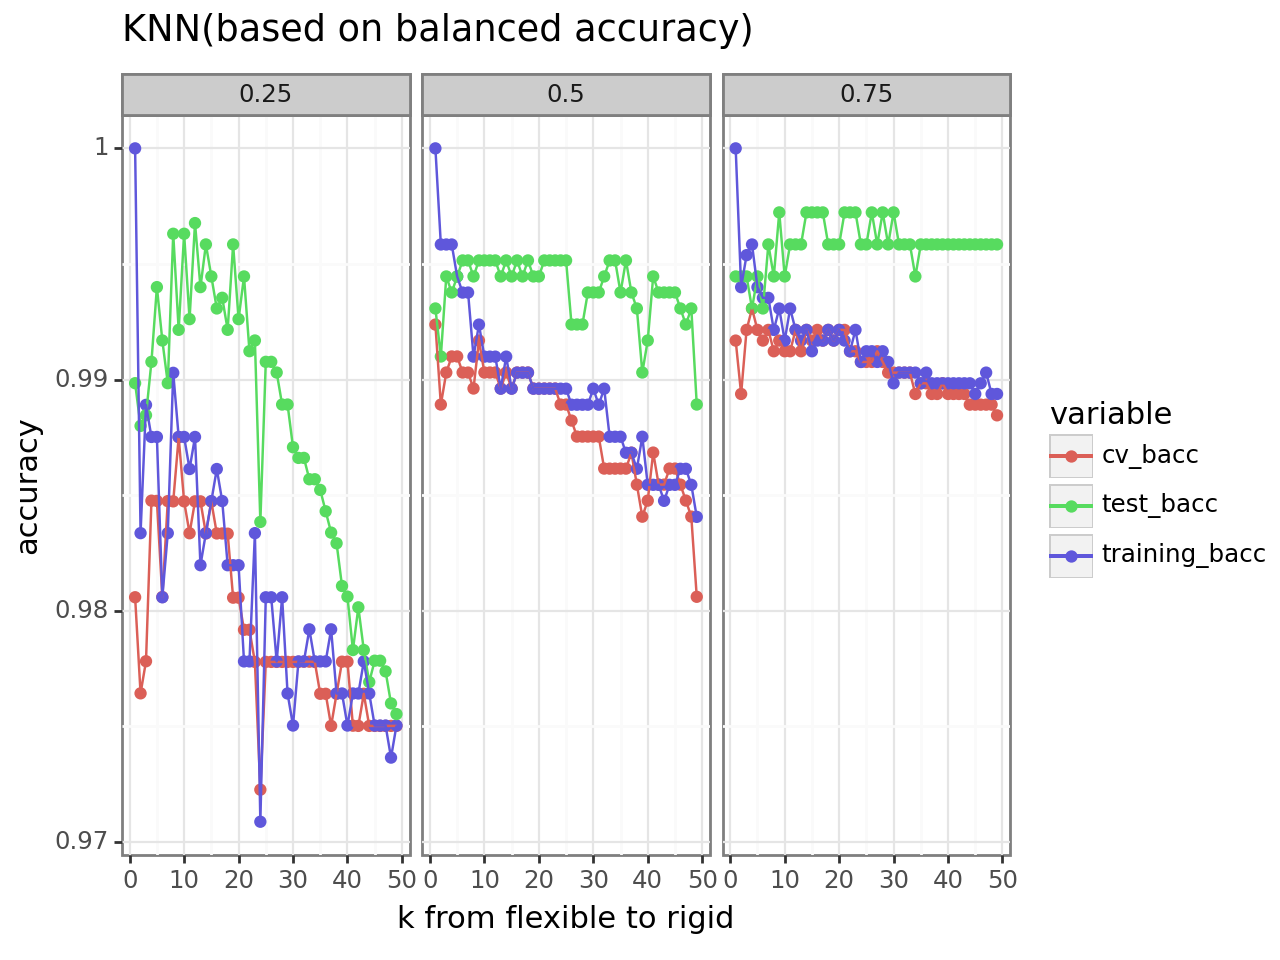

<Figure Size: (640 x 480)>

In [62]:
df_results_dfknn = pd.melt(results_dfknn, id_vars=["k", 'trainning size'], value_vars=["cv_bacc", 'training_bacc', 'test_bacc'])
p1 = (ggplot(df_results_dfknn, aes(x = 'k', y = 'value', color = 'variable'))
      + geom_point()
      + geom_line()
      + facet_wrap('trainning size', nrow = 1)
      + labs(x = 'k from flexible to rigid', y = 'accuracy', title = 'KNN(based on balanced accuracy)')
      + theme_minimal()
      + theme_bw()
      )
p1

In [21]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", message="Scoring failed.*")
warnings.filterwarnings("ignore", message="Scoring failed. The accuracy and F1-score will default to 0.")


In [33]:
results_dfknn = pd.DataFrame(columns=['trainning size', 'k', 'optimal_pc', 'cv_f1', 'training_f1', 'test_f1'])

for q in [1, 2, 3]:
    size = q * 0.25

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        stratify=y,
        train_size=size,
        random_state=0)

    evaluator = ModelEvaluator(X_train, X_test, y_train, y_test, 'knn')


    for k in range(1, 50):
        optimal_pc, cv_f1, training_f1, test_f1 = evaluator.find_optimal_pc_with_cv(k, scoring='f1_macro')
        results_dfknn.loc[len(results_dfknn)] = [size, k, optimal_pc, cv_f1, training_f1, test_f1]

print(results_dfknn.head())

   trainning size    k  optimal_pc     cv_f1  training_f1   test_f1
0            0.25  1.0         1.0  0.761437     1.000000  0.735457
1            0.25  2.0         1.0  0.753103     0.879334  0.751616
2            0.25  3.0         1.0  0.776686     0.859917  0.777470
3            0.25  4.0         1.0  0.776657     0.850208  0.777470
4            0.25  5.0         1.0  0.787787     0.844660  0.788550


d:\anaconda3\lib\site-packages\mizani\scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
d:\anaconda3\lib\site-packages\mizani\scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


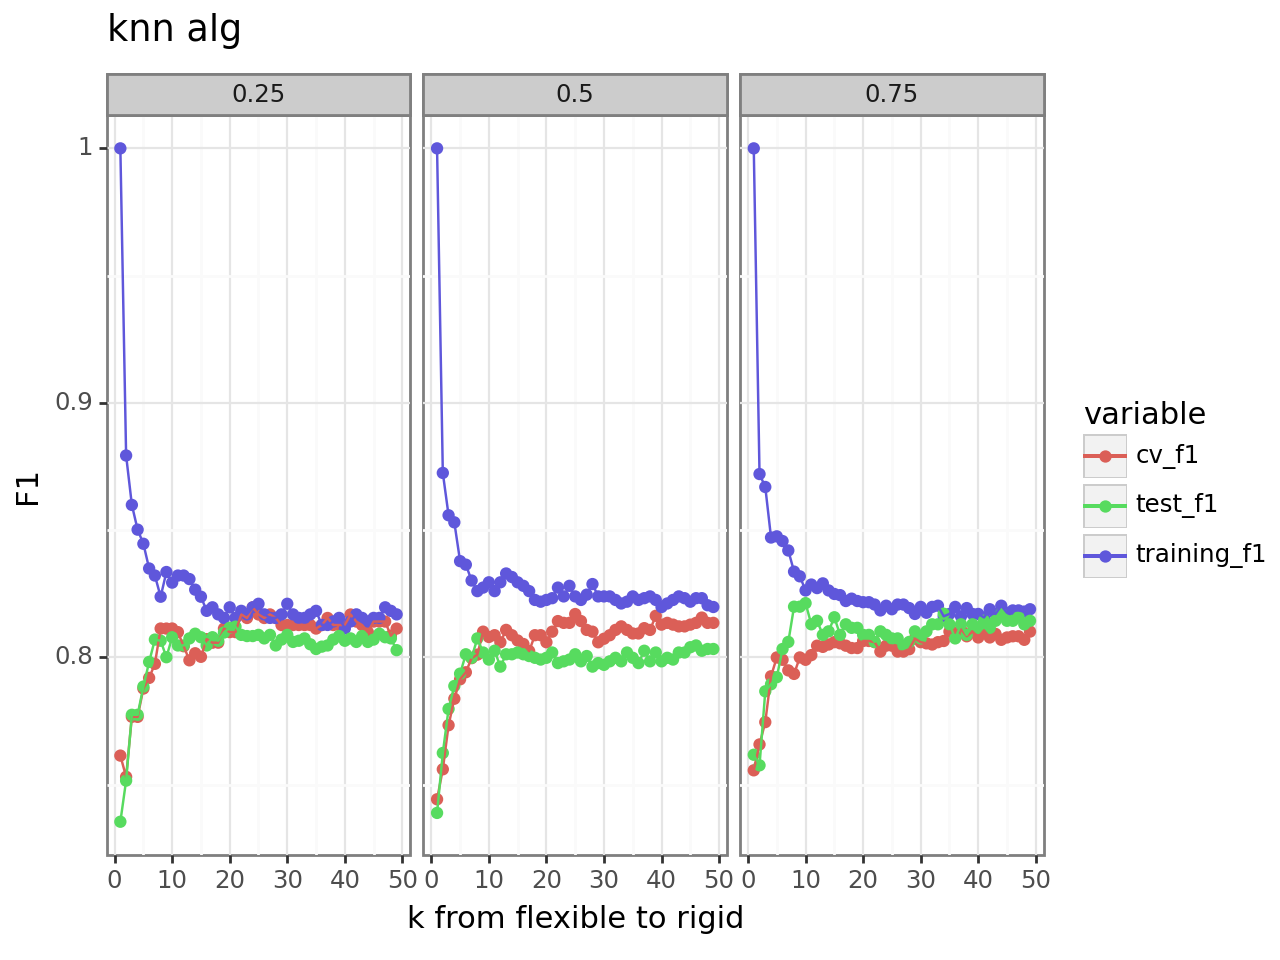

<Figure Size: (640 x 480)>

In [34]:
df_results_dfknn = pd.melt(results_dfknn, id_vars=["k", 'trainning size'], value_vars=["cv_f1", 'training_f1', 'test_f1'])
p1 = (ggplot(df_results_dfknn, aes(x = 'k', y = 'value', color = 'variable'))
      + geom_point()
      + geom_line()
      + facet_wrap('trainning size', nrow = 1)
      + labs(x = 'k from flexible to rigid', y = 'F1', title = 'knn alg')
      + theme_minimal()
      + theme_bw()
      )
p1